# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime as dt
%matplotlib inline

# Procesamiento de los datos

In [2]:

file_path = './datos/precios/Precio_Bolsa_Nacional_($kwh)_'

complete_df = None
for year in range(1995,2019):
    extension = 'xlsx'
    if (year >= 2016):
        extension = 'xls'
    filestring = file_path + str(year) +'.'+ extension
    skiprows=3
    if (year >= 2000):
        skiprows = 2
    df = pd.read_excel(filestring,skiprows=skiprows)
    means = []
    df = df.dropna(axis='index', thresh=10)
    df = df.dropna(axis='columns', how='all')
    for index, row in df.iterrows():
        s = 0
        c = 0
        for i in range(0,24):
            value = row[str(i)]
            if (not pd.isnull(value)):
                s += float(value)
                c += 1
        prom = s/c
        means.append(prom)
    df['Mean'] = means
    if (year == 1995):
        complete_df = df
    else:
        complete_df = complete_df.append(df)
parsed_dates = []
for d in complete_df['Fecha'].values:
    if (isinstance(d,str)):
        parsed_dates.append(dt.datetime.strptime(d,"%Y-%m-%d"))
    elif (isinstance(d,dt.datetime)):
        parsed_dates.append(d)
    else:
        print(d)
        print(type(d))
complete_df['Parse Date'] = pd.to_datetime(parsed_dates)

complete_df['Timestamp'] = [d.timestamp() for d in parsed_dates]
complete_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,Mean,NaN,Unnamed: 26,Timestamp
count,8396.000000,8396.000000,8399.000000,8397.000000,8400.000000,8400.000000,8395.000000,8400.000000,8398.000000,8400.000000,...,8400.000000,8400.000000,8400.000000,8399.000000,8400.000000,8399.000000,8400.000000,365.000000,1096.000000,8.400000e+03
mean,94.894760,92.225018,90.481800,89.820847,91.875322,97.393668,98.849377,102.907985,107.703317,110.057409,...,124.882346,132.515216,121.136281,113.722311,105.951791,99.023616,107.256202,75.013184,172.728791,1.164668e+09
std,123.549943,118.820196,117.353192,113.791278,114.577197,121.587657,121.585878,126.268919,131.341183,132.971299,...,139.447157,140.298005,137.610502,135.153642,131.446948,125.436527,128.372835,21.329104,86.094551,2.077268e+08
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.100000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.499792,35.356674,38.397980,8.062164e+08
25%,37.347355,36.879062,36.364631,36.246583,37.321099,39.553350,39.958856,42.157859,45.211945,46.169674,...,56.737062,62.877671,55.580568,49.984394,43.917158,39.039229,46.001686,59.497735,132.496797,9.839196e+08
50%,65.866872,64.739182,64.123530,63.978184,65.210519,67.996943,69.255438,71.540069,74.644855,76.273409,...,90.169674,96.074484,85.976229,79.255884,72.459721,67.868907,74.653875,72.466983,162.804898,1.165338e+09
75%,116.394779,113.634484,111.184232,110.831014,113.713497,120.283444,122.090915,125.807304,130.596225,133.405265,...,153.683890,166.491698,148.158058,136.762786,129.378072,123.197570,132.123855,89.774928,191.236969,1.344078e+09
max,1942.776133,1942.776133,1942.776133,1940.837460,1942.776133,1942.776133,1942.776133,1955.820551,2821.520551,1942.776133,...,1955.820551,1955.820551,1942.820551,1946.437460,1955.820551,1944.516236,1942.692800,130.143544,478.874958,1.525496e+09


In [3]:
complete_df.head()


,Fecha,0,1,2,3,4,5,6,7,8,...,20,21,22,23,Mean,Version,NaN,Unnamed: 26,Parse Date,Timestamp
0,1995-07-20,NaN,1.073,1.073,1.073,1.073,1.073,1.073,1.073,1.074,...,1.897,1.897,1.073,1.073,1.409435,NaN,NaN,NaN,1995-07-20,806216400.0
1,1995-07-21,1.073,1.000,1.000,1.000,1.000,1.000,5.000,6.000,6.000,...,11.929,5.000,1.000,1.000,4.924333,NaN,NaN,NaN,1995-07-21,806302800.0
2,1995-07-22,1.073,1.073,1.000,1.000,1.000,1.073,1.303,1.303,1.303,...,2.500,1.303,1.073,1.073,1.269500,NaN,NaN,NaN,1995-07-22,806389200.0
3,1995-07-23,1.073,1.000,1.000,1.000,1.000,1.000,0.100,1.000,1.000,...,1.238,1.238,1.073,1.000,0.953083,NaN,NaN,NaN,1995-07-23,806475600.0
4,1995-07-24,1.000,1.000,0.990,1.000,1.000,1.073,3.000,3.000,3.000,...,9.256,3.000,1.073,1.000,4.305917,NaN,NaN,NaN,1995-07-24,806562000.0


## Gráfica de la tendencia promedio de los precios

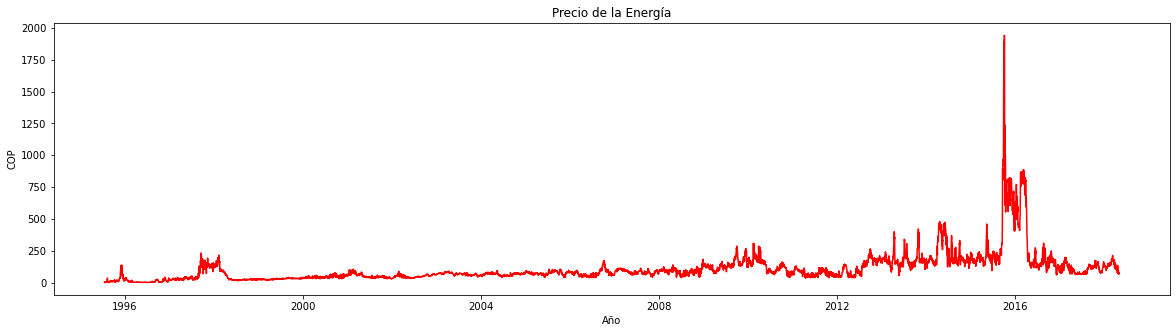

In [4]:
complete_df.sort_values(by='Parse Date')
complete_df.drop_duplicates(subset="Parse Date", keep="first", inplace=True)
plt.figure(figsize=(20,5))
plt.title('Precio de la Energía')
plt.xlabel('Año')
plt.ylabel('COP')
plt.plot(complete_df['Parse Date'], complete_df['Mean'], color='red')
plt.show()

## IPC 
Es necesario normalizar los datos multiplicandolos por el IPC histórico y así poder descartar la inflación como variable de cambio, para esto se hará uso del archivo de excel 'ipc_historico.xlsx, que también se encuentra en la carpeta de datos, este archivo se obtuvo de la página web del <a href="https://www.banrep.gov.co/es/estadisticas/indice-precios-consumidor-ipc" target="_blank">Banco de la República</a>  

In [5]:
ipc_df = pd.read_excel('./datos/precios/series_ipc_historico.xlsx', skiprows=12, parse_dates=True)
ipc_df = ipc_df.dropna(axis='index', thresh=2)
ipc_df = ipc_df.dropna(axis='columns', how='all')
ipc_df['Parse Date'] = [dt.datetime.strptime(str(d),"%Y%m") for d in ipc_df['Año(aaaa)-Mes(mm)'].tolist()]
ipc_df.sort_values(by='Parse Date', inplace=True)
ipc_df.tail()



,Año(aaaa)-Mes(mm),Índice,Inflación anual,Inflación mensual,Inflación año corrido,Parse Date
4,201910,103.43,0.0386,0.0016,0.0343,2019-10-01
3,201911,103.54,0.0384,0.0010,0.0354,2019-11-01
2,201912,103.80,0.0380,0.0026,0.0380,2019-12-01
1,202001,104.24,0.0362,0.0042,0.0042,2020-01-01
0,202002,104.94,0.0372,0.0067,0.0109,2020-02-01


In [6]:
#Obtenemos el IPC base
mask = (ipc_df['Índice'] == 100)
base_ipc_df = ipc_df.loc[mask]
base_ipc_df.head()

,Año(aaaa)-Mes(mm),Índice,Inflación anual,Inflación mensual,Inflación año corrido,Parse Date
14,201812,100.0,0.0318,0.003,0.0318,2018-12-01


In [7]:
base_ipc = base_ipc_df['Índice'].tolist()[0]
print(base_ipc)

100.0


In [8]:
normalized_means = []
for m,d in zip(complete_df['Mean'].tolist(), complete_df['Timestamp'].tolist()):
    date = dt.datetime.utcfromtimestamp(d)
    mask = (ipc_df['Parse Date'].dt.year == date.year) & (ipc_df['Parse Date'].dt.month == date.month)
    ipc = ipc_df.loc[mask]['Índice'].values[0]
    normalized_price = m * (base_ipc/ipc)
    normalized_means.append(normalized_price)

complete_df['Precio Normalizado'] = normalized_means    

complete_df.tail()

,Fecha,0,1,2,3,4,5,6,7,8,...,21,22,23,Mean,Version,NaN,Unnamed: 26,Parse Date,Timestamp,Precio Normalizado
120,2018-05-01,64.229226,64.229226,64.129226,64.129226,64.129226,64.129226,64.129226,64.229226,64.229226,...,81.229226,71.229226,64.229226,71.666726,TX2,NaN,NaN,2018-05-01,1.525151e+09,72.273826
121,2018-05-02,63.332816,63.332816,63.332816,63.332816,63.332816,64.332816,67.832816,79.831816,80.832816,...,80.832816,80.832816,67.832816,76.374441,TX2,NaN,NaN,2018-05-02,1.525237e+09,77.021421
122,2018-05-03,63.710848,64.210848,61.710848,61.710848,63.710848,64.210848,64.210848,67.710848,67.710848,...,67.710848,67.710848,63.710848,71.148348,TX1,NaN,NaN,2018-05-03,1.525324e+09,71.751057
123,2018-05-04,61.543453,61.543453,61.543453,61.543453,61.543453,65.543453,61.543453,64.043453,65.543453,...,65.543453,65.543453,64.043453,64.710120,TX1,NaN,NaN,2018-05-04,1.525410e+09,65.258289
124,2018-05-05,73.742918,73.742918,70.242918,70.242918,70.242918,70.242918,73.742918,73.742918,75.242918,...,75.242918,75.242918,75.242918,73.972085,TX1,NaN,NaN,2018-05-05,1.525496e+09,74.598714


## Comparación de Precio vs Precio Normalizado

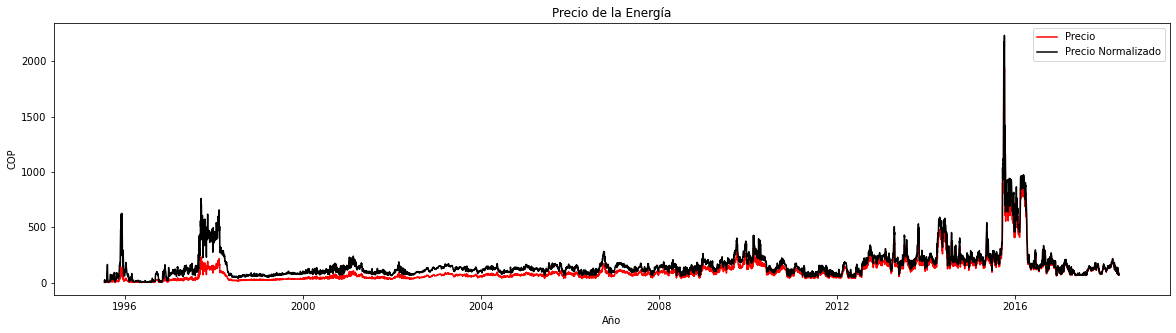

In [9]:
plt.figure(figsize=(20,5))
plt.title('Precio de la Energía')
plt.xlabel('Año')
plt.ylabel('COP')
plt.plot(complete_df['Parse Date'], complete_df['Mean'], label="Precio", color='red')
plt.plot(complete_df['Parse Date'], complete_df['Precio Normalizado'], label="Precio Normalizado", color='black')
plt.legend()
plt.show()

# Transformación de los Datos
Finalizado el proceso de preprocesamiento, se conformará un nuevo dataframe con los datos estrictamente necesarios, y una a una se irán agregando las transformaciones a los precios normalizados. Las transformaciones a usar serán:
<ul>
    <li>Logaritmo natural</li>
    <li>Raíz cuadrada</li>
    <li>Raíz cúbica</li>
</ul>

In [10]:
##Nuevo dataframe solo con los datos requeridos
df_dict = {
    "Fecha": complete_df['Parse Date'],
    "Timestamp": complete_df['Timestamp'],
    "Precio_Promedio": complete_df['Mean'],
    "Precio_Normalizado": complete_df['Precio Normalizado']
}
df = pd.DataFrame(df_dict)
##Le agregamos las distintas transformaciones al precio normalizado
df['Log_Natural'] = np.log(df['Precio_Normalizado'].tolist())
df['Raiz_Cuadrada'] = np.sqrt(df['Precio_Normalizado'].tolist())
df['Raiz_Cubica'] = np.cbrt(df['Precio_Normalizado'].tolist())
df.describe()

,Timestamp,Precio_Promedio,Precio_Normalizado,Log_Natural,Raiz_Cuadrada,Raiz_Cubica
count,8.326000e+03,8326.000000,8326.000000,8326.000000,8326.000000,8326.000000
mean,1.165854e+09,107.497293,159.682949,4.818459,11.856760,5.128808
std,2.076787e+08,128.747068,148.263375,0.740336,4.370639,1.219586
min,8.062164e+08,0.499792,2.387920,0.870423,1.545290,1.336616
25%,9.860364e+08,46.297403,89.982346,4.499613,9.485902,4.481112
50%,1.165856e+09,74.706517,125.280368,4.830554,11.192871,5.003735
75%,1.345676e+09,132.281824,176.898179,5.175574,13.300307,5.613596
max,1.525496e+09,1942.692800,2233.493676,7.711322,47.259853,13.071585


## Gráfica comparativa de cada una de las transformaciones

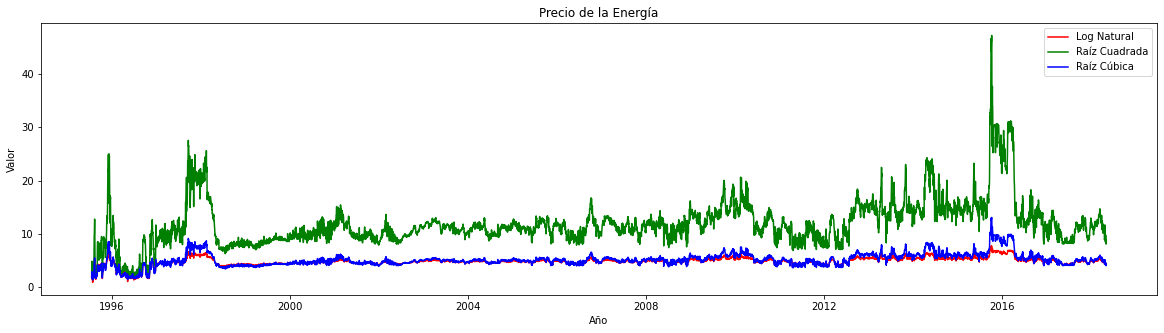

In [11]:
plt.figure(figsize=(20,5))
plt.title('Precio de la Energía')
plt.xlabel('Año')
plt.ylabel('Valor')
#plt.plot(df['Fecha'], df['Precio_Normalizado'], label="Precio Normalizado", color='black')
plt.plot(df['Fecha'], df['Log_Natural'], label="Log Natural", color='red')
plt.plot(df['Fecha'], df['Raiz_Cuadrada'], label="Raíz Cuadrada", color='green')
plt.plot(df['Fecha'], df['Raiz_Cubica'], label="Raíz Cúbica", color='blue')

plt.legend()
plt.show()

## Elección de la Transformación

Para elegir la transformación adecuada se realizará el modelo, se hará un pronóstico y se seleccionará aquella transformación con menor error


### Implementación del Modelo

La implementación del modelo escogida es la propuesta por el profesor en el siguiente <a href="https://jdvelasq.github.io/courses/notebooks/tensorflow/adaline/1-01-adalines.html" target="_blank">enlace</a>

In [12]:
class Adaline:
    def __init__(self,
                 learning_rate=0.001, # tasa de aprendizaje
                 max_epochs=100,      # número máximo de iteraciones sobre el set de datos
                 shuffle=False,       # mezcla patrones para aprendizaje online
                 random_state=None,   #
                 warm_start=False):   #

        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.shuffle = shuffle
        self.random_state = random_state
        self.warm_start = warm_start
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):

        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if not isinstance(y, np.ndarray):
            d = np.array(y)
        else:
            d = y.copy()

        if self.random_state is not None:
            np.random.RandomState(self.random_state)

        if self.coef_ is None or self.warm_start is False:
            self.coef_ = np.random.uniform(-1, 1, X.shape[1])

        if self.intercept_ is None  or self.warm_start is False:
            self.intercept_ = np.random.uniform(-1, 1, 1)

        errors2 = []
        forecasts = []

        for epoch in range(self.max_epochs):

            if self.shuffle is True:
                n = list(range(X.shape[0]))
                np.random.shuffle(n) #Desordena una lista de indices
                X = X[n,:] 
                d = d[n]

            for i in range(X.shape[0]):
                u = np.dot(X[i,:], self.coef_) + self.intercept_ 
                """print(X[i,:])
                print(" * ")
                print(self.coef_)
                print(" + ")
                print(self.intercept_)
                print(" = ")
                print(u)
                print(" ---------------------- ")"""
                e = (d[i] - u)[0]
                self.coef_ += 2 * self.learning_rate * e * X[i,:]
                self.intercept_ += 2 * self.learning_rate * e
                errors2.append(e**2)
                forecasts.append(u)

        return errors2, forecasts

    def predict(self, X):
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        u = np.dot(X, self.coef_) + self.intercept_
        return u

In [14]:
transformations = ['Log_Natural', 'Raiz_Cuadrada', 'Raiz_Cubica']

L = 7
desireds_d = dict()
forecasts_d = dict()
errors2_d = dict()

for trans in transformations:
    d = df[trans].tolist()
    desireds_d[trans] = d
    X = []
    for t in range(L, len(d)):
        X.append(d[t-L:t].copy())
        
    adaline = Adaline(
    learning_rate=0.001,  # tasa de aprendizaje
    max_epochs=1,        # número máximo de iteraciones sobre el set de datos
    shuffle=False,       # mezcla patrones para aprendizaje online
    random_state=123,    # corrida reproducible
    warm_start=False)    # inicia con pesos aleatorios
    
    errors2, forecasts = adaline.fit(X,d[L:])
    forecasts_d[trans] = forecasts
    errors2_d[trans] = errors2



c:\users\sergio\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: overflow encountered in double_scalars
c:\users\sergio\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in add
c:\users\sergio\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in add


c:\users\sergio\appdata\local\programs\python\python37\lib\site-packages\matplotlib\ticker.py:2192: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


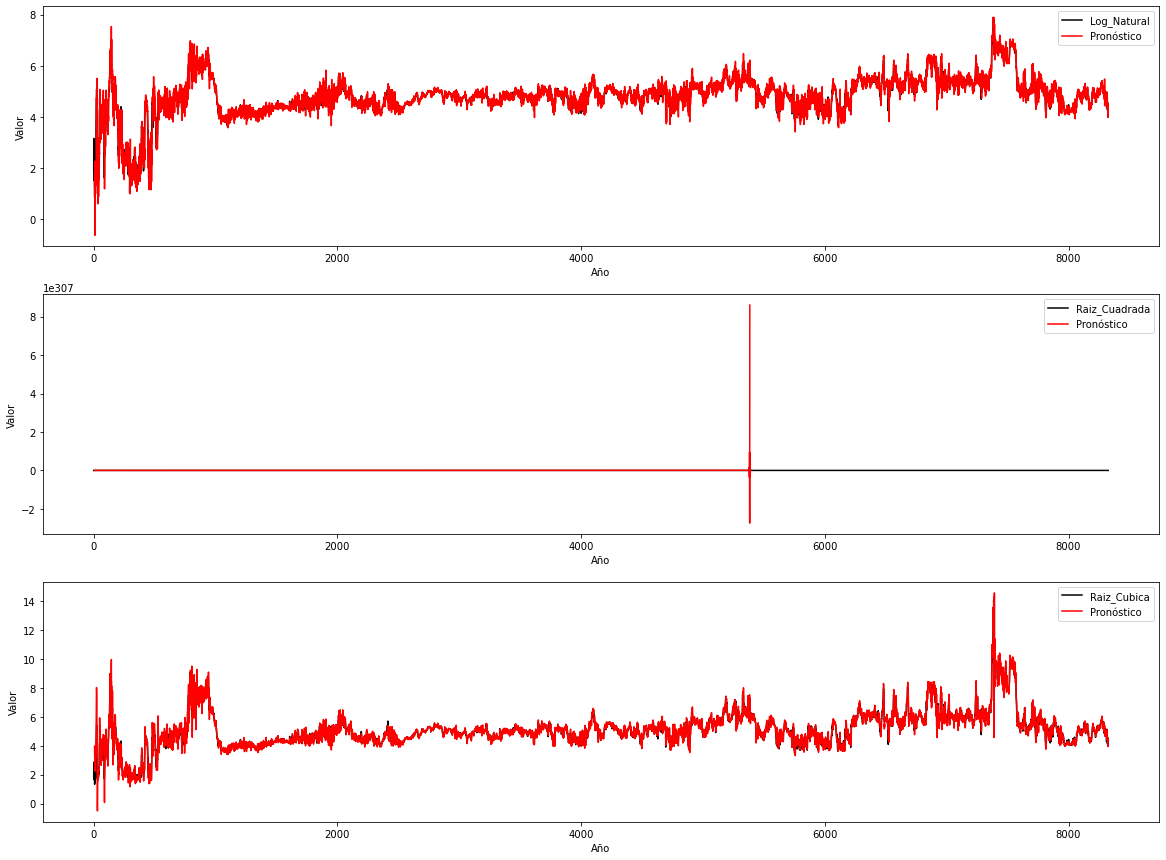

In [19]:
plt.figure(figsize=(20,15)) 
for i in range(len(transformations)):
    trans = transformations[i]
    plt.subplot(3,1,i+1)   
    plt.xlabel('Año')
    plt.ylabel('Valor')
    plt.plot(desireds_d[trans], label=trans, color='black')
    plt.plot(range(L, len(desireds_d[trans])),forecasts_d[trans], label="Pronóstico", color='red')
    plt.legend()


Observando el comportamiento de los pronósticos, se procedera a realizar el análisis del error sobre las transformaciones de Logaritmo Natural y Raíz Cúbica, se descarta la Raíz Cuadrada por su comportamiento sumamente errático sobre la misma tasa de aprendizaje (0.001)

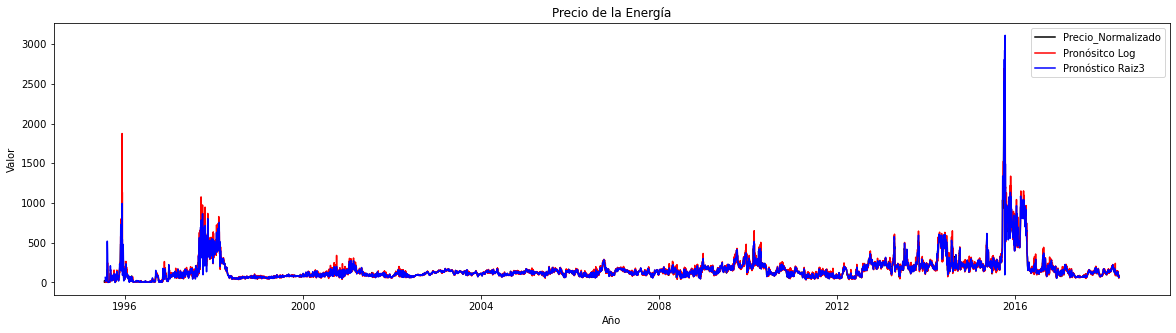

In [26]:
## Aplicando la transformación inversa
forecast_inv = dict()
forecast_inv['Log_Natural'] = np.exp(forecasts_d['Log_Natural'])
forecast_inv['Raiz_Cubica'] = np.power(forecasts_d['Raiz_Cubica'],3)

plt.figure(figsize=(20,5))
plt.title('Precio de la Energía')
plt.xlabel('Año')
plt.ylabel('Valor')
first_date = dt.datetime.utcfromtimestamp(df['Timestamp'].tolist()[0])
date_thresh = (df['Fecha'] >= first_date + dt.timedelta(L-1))
dates_df = df.loc[date_thresh]['Fecha']
plt.plot(df['Fecha'],df['Precio_Normalizado'], label="Precio_Normalizado", color='black')
plt.plot(dates_df,forecast_inv["Log_Natural"], label="Pronósitco Log", color='red')
plt.plot(dates_df,forecast_inv["Raiz_Cubica"], label="Pronóstico Raiz3", color='blue')

plt.legend()
plt.show()

Realizando la comparación se puede notar que ambas transformaciones funcionan bastante bien para el pronóstico, ahora se procederá a evaluar el error.

In [35]:
error_log = 0
error_cbrt = 0
d_normalizado = df['Precio_Normalizado'].tolist()
print(d_normalizado[7])
print(forecast_inv['Log_Natural'][0])
print(d_normalizado[7] - forecast_inv['Log_Natural'][0])
for i in range(len(forecast_inv['Log_Natural'])):
    d = d_normalizado[i+L]
    ul = forecast_inv['Log_Natural'][i]
    uc = forecast_inv['Raiz_Cubica'][i]
    error_log = error_log + (d - ul)**2
    error_cbrt = error_log + (d - uc)**2

print("La suma total del error cuadrático para la transformación de Log Natural es: {}".format(error_log))
print("La suma total del error cuadrático para la transformación de Raiz Cúbica es: {}".format(error_cbrt))    

    


2.799609810479376
[5.43549646]
[-2.63588665]
La suma total del error cuadrático para la transformación de Log Natural es: [21395869.81744317]
La suma total del error cuadrático para la transformación de Raiz Cúbica es: [21395934.2631393]
